In [539]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import math
from scipy.optimize import minimize 

In [854]:
# Generate data
global inputs
global targets
global N

classA = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5], np.random.randn(10, 2) * 0.2 + [-1.5, 0.5])) 
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]
# classB = np.random.randn(20, 2) * 0.2 + [0.5, 0.0]

inputs = np.concatenate((classA, classB)) 
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

np.random.seed(100)
N = inputs.shape [0] # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute,:]
targets = targets[permute]

# inputs = np.array([[0,1],[0,-1], [-1, 0.5], [-1, -1.5]])
# targets = np.array([1,-1,1,-1])
# N = 4

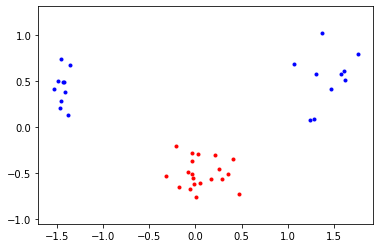

In [855]:
# Plot data

plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.axis('equal')
plt.show()

In [856]:
# Kernels

def linear_kernel(x1, x2):
    """The linear kernel returns the dot product between the two datapoints 
    x1 and x2"""
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2):
    """Returnes the value of the polynomial kernel between the vectors x1 and x2"""
    p = 2   # Tuning parameter
    return ((np.dot(x1,x2) + 1) ** p)

def RBF_kernel(x1, x2):
    """"Returnes the value of the RBF kernel between the vectors x1 and x2"""
    sigma = 0.5   # Tuning parameter
    exponential = -1 * ((np.linalg.norm(x1-x2) ** 2) / (2 * (sigma ** 2)))
    return np.exp(exponential)

In [885]:
# Precompute

kernel = linear_kernel      # Declare which kernel to use for the computations
C = np.inf                  # Specify the value of the slack paramter

kappa = np.zeros((N,N))  # Precompute matrix storing values of kenel function applied to vector i and j in entry(i,j)
for i in range(N):
    for j in range(N):
        x1 = inputs[i,:]
        x2 = inputs[j,:]
        kappa[i,j] = kernel(x1, x2)
        
global P
P = np.zeros((N,N))      # Matrix to store results for efficient computations
for i in range(N):
    for j in range(N):
        P[i,j] = targets[i] * targets[j] * kappa[i,j]

In [886]:
# Define functions for what to optimize under which constraints

def objective(alpha):
    """Returnes the value of the objective function for a certain alpha vector"""
#     first_sum = 0.5 * (np.sum(np.multiply(alpha @ alpha.T, P)))
#     second_sum = np.sum(alpha)
#     return first_sum - second_sum
    value = 0
    for i in range(N):
        for j in range(N):
            value += alpha[i] * alpha[j] * P[i,j]
    value *= 0.5
    value -= np.sum(alpha)
    return value

def zerofun(alpha):
    """Returnes the values of the constraint. The constraint is supposed to 
    be zero."""
    return np.dot(alpha, targets)


In [887]:
# Call minimize to minimize alpha with appropriate constraints

# Find alpha vector
initial_guess = np.zeros(N)
B = [(0,C) for i in range(N)]  # Lägg till C som upper bound om det behövs för slack
XC = {'type':'eq', 'fun':zerofun}
returned = minimize(objective, initial_guess, bounds=B, constraints=XC)
alpha = returned['x']
found_solution = returned['success']
print(found_solution)

# Extract non-zero alpha values from alpha vector
global nonzero_alphas, corresponding_inputs, corresponding_targets
nonzero_alphas = []
corresponding_inputs = []
corresponding_targets = []
nonzero_index = []
threshold = 10 ** (-5)   # Due to dealing with floating point numbers


# Store them in lists
for i in range(len(alpha)):
    if alpha[i] > threshold:
        nonzero_alphas.append(alpha[i])
        corresponding_inputs.append(inputs[i,:])
        corresponding_targets.append(targets[i])
        nonzero_index.append(i)
corresponding_inputs = np.array(corresponding_inputs)  # Convert to numpy array

True


In [888]:
# Calculate b

for i in range(len(nonzero_alphas)):
    if nonzero_alphas[i] < C:
        index_SV = i
        break
        
global b
b = 0
support_vector = corresponding_inputs[index_SV,:]
for i in range(len(nonzero_alphas)):
    ker = kernel(support_vector, corresponding_inputs[i,:])
    b += nonzero_alphas[i] * corresponding_targets[i] * ker
b -= corresponding_targets[index_SV]

In [889]:
# Indicator function

def indicator(s, kernel):
    """Classifies as one if ind > 0 and as minus one otherwise. kernel is the kernel function that will be used.
    """
    s = np.array(s)
    ind = 0
    for i in range(len(nonzero_alphas)):
        ind += nonzero_alphas[i] * corresponding_targets[i] * kernel(s, corresponding_inputs[i,:])
    ind -= b
    return ind

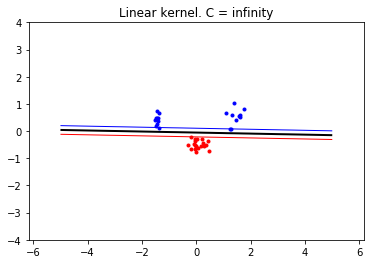

In [892]:
# Plot desicion boundary

xgrid = np.linspace(-5,5) 
ygrid = np.linspace(-4,4)
grid = np.array([[indicator([x,y], kernel) for x in xgrid] for y in ygrid])
plt.contour(xgrid, ygrid, grid.round(2), (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1,2,1))
# plt.plot([p[0] for p in inputs], [p[1] for p in inputs], 'g.', markersize=12)

plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.axis('equal')
plt.title('Linear kernel. C = infinity')
plt.savefig('svmplotsCinf_linear_kernel.pdf')
plt.show()